In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import os
from tqdm import tqdm
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

In [54]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [46]:
# class UNet(nn.Module):
#     def __init__(self, input_channels=1, num_classes=1):
#         super(UNet, self).__init__()
        

#         self.conv1 = nn.Sequential(
#             nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(32, 32, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.conv5 = nn.Sequential(
#             nn.Conv2d(256, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )
        
#         self.upconv6 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
#         self.conv6 = nn.Sequential(
#             nn.Conv2d(512, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )
#         self.upconv7 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         self.conv7 = nn.Sequential(
#             nn.Conv2d(256, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )
#         self.upconv8 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
#         self.conv8 = nn.Sequential(
#             nn.Conv2d(128, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )
#         self.upconv9 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
#         self.conv9 = nn.Sequential(
#             nn.Conv2d(64, 32, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(32, 32, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )
#         self.conv10 = nn.Conv2d(32, num_classes, kernel_size=1)
        
#     def forward(self, x):
#         enc1 = self.conv1(x)
#         enc2 = self.conv2(enc1)
#         enc3 = self.conv3(enc2)
#         enc4 = self.conv4(enc3)
#         enc5 = self.conv5(enc4)
        
#         dec6 = self.upconv6(enc5)
#         dec6 = self.conv6(torch.cat([dec6, enc4], dim=1))
        
#         dec7 = self.upconv7(dec6)
#         dec7 = self.conv7(torch.cat([dec7, enc3], dim=1))
        
#         dec8 = self.upconv8(dec7)
#         dec8 = self.conv8(torch.cat([dec8, enc2], dim=1))
        
#         dec9 = self.upconv9(dec8)
#         dec9 = self.conv9(torch.cat([dec9, enc1], dim=1))
        
#         out = self.conv10(dec9)
        
#         return out


In [36]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")  
        mask = Image.open(self.mask_paths[idx]).convert("L")    

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [37]:
image_path = "/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png"
mask_path = "/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/masks"

In [55]:
image_paths = sorted(glob(os.path.join(image_path, "*.png")))
mask_paths = sorted(glob(os.path.join(mask_path, "*.png")))

image_names = [os.path.basename(image_path).replace(".png", "") for image_path in image_paths]
mask_names = [os.path.basename(mask_path).replace("_mask.png", "") for mask_path in mask_paths]
common_names = set(image_names).intersection(mask_names)

image_paths_filtered = [image_path for image_path in image_paths if os.path.basename(image_path).replace(".png", "") in common_names]
mask_paths_filtered = [mask_path for mask_path in mask_paths if os.path.basename(mask_path).replace("_mask.png", "") in common_names]

train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(
    image_paths_filtered, mask_paths_filtered, test_size=0.1, random_state=42
)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_dataset = CustomDataset(train_image_paths, train_mask_paths, transform=transform)
test_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1).to(device)


In [53]:

criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=2e-4)


In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        
        outputs = torch.nn.functional.interpolate(outputs, size=(256, 256), mode='bilinear', align_corners=False)
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

Epoch 1/5: 100%|██████████| 32/32 [03:27<00:00,  6.47s/it]


Epoch 1/5, Train Loss: 0.7024


Epoch 2/5: 100%|██████████| 32/32 [03:29<00:00,  6.55s/it]


Epoch 2/5, Train Loss: 0.7024


Epoch 3/5: 100%|██████████| 32/32 [03:31<00:00,  6.61s/it]


Epoch 3/5, Train Loss: 0.7024


Epoch 4/5: 100%|██████████| 32/32 [03:33<00:00,  6.67s/it]


Epoch 4/5, Train Loss: 0.7024


Epoch 5/5:   9%|▉         | 3/32 [00:20<03:19,  6.87s/it]

In [41]:
model.eval()
test_loss = 0.0

predictions = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images, masks = images.to(device), masks.to(device)
        
        outputs = model(images)
        
        outputs = torch.nn.functional.interpolate(outputs, size=(256, 256), mode='bilinear', align_corners=False)
        
        loss = criterion(outputs, masks)
        
        test_loss += loss.item() * images.size(0)
        
        predictions.append(outputs > 0.5)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

predictions = torch.cat(predictions, dim=0)

Testing: 100%|██████████| 4/4 [00:16<00:00,  4.08s/it]

Test Loss: 0.2803


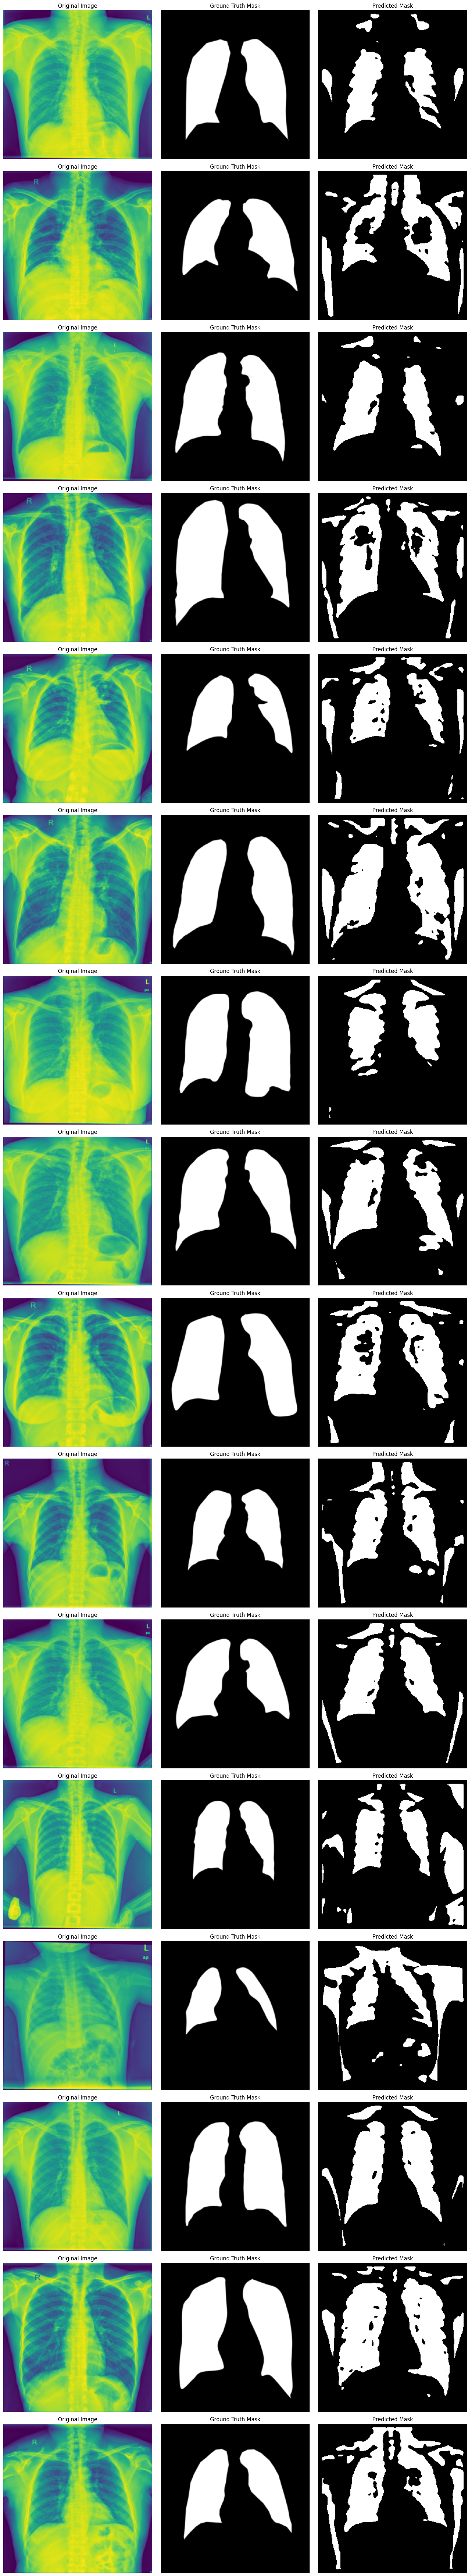

In [42]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def plot_images(images, masks, predictions):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5*num_images))
    for i in range(num_images):
        axes[i, 0].imshow(images[i].permute(1, 2, 0))
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")
        
        axes[i, 2].imshow(predictions[i].squeeze().cpu().numpy(), cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")
    plt.tight_layout()
    plt.show()

sample_images, sample_masks = next(iter(test_loader))
sample_images, sample_masks = sample_images.to(device), sample_masks.to(device)
sample_outputs = model(sample_images)
sample_outputs = torch.nn.functional.interpolate(sample_outputs, size=(256, 256), mode='bilinear', align_corners=False)
sample_predictions = sample_outputs > 0.5

plot_images(sample_images, sample_masks, sample_predictions)
